# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [34]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [1]:
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import time

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.fit_transform(X)
        if self.use_PCA:
          self.pca = PCA(n_components=self.new_dim, random_state = 42)
          X_copy = self.pca.fit_transform(X)

        self.W, self.b = self._find_W_b(X_copy)
        X_copy = self.scaler2.fit_transform(np.cos(X_copy @ self.W + self.b))
              
        # LinearModel
        if self.classifier == 'svm':
            self.clf = SVC(kernel='linear', probability=True, random_state=42)
        elif self.classifier == 'logreg':
            self.clf = LogisticRegression(n_jobs=-1, random_state=42)
        else:
            raise NotImplementedError('{} is not supported'.format(self.classifier))
        self.clf.fit(X_copy, y)
        return self

    def _find_W_b(self, X): 
        i = np.random.choice(X.shape[0], 2000)
        i = np.unique(i)
        j = np.random.choice(list(set([k for k in range(X.shape[0])]) - set(i)), 2000) 
        j = np.unique(j)
        dist = cdist(X[i], X[j]).flatten() 
        sigma = np.median(dist)
        W = np.random.normal(0, 1/sigma, size=(X.shape[1], self.n_features))
        b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        return W, b

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.transform(X)
        if self.use_PCA:
            X_copy = self.pca.transform(X)
        X_copy = self.scaler2.transform(np.cos(X_copy @ self.W + self.b))
        preds_proba = self.clf.predict_proba(X_copy)
        return preds_proba
                
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        preds_proba = self.predict_proba(X)
        preds = np.argmax(preds_proba, axis=1)
        return preds
#Частично заимствовано из
#https://github.com/SamburskyAlexander/ML-DL/blob/6833eb39b43e5f2c30e83cb931278c03d4c2ff11/ML_fragments.ipynb

In [6]:
%%time
RFFPipe = RFFPipeline()
RFFPipe.fit(x_train, y_train)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_logreg = np.argmax(preds_probs, axis=1)
print('RFF LogReg accuracy =', round(accuracy_score(y_test, preds_rff_logreg), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_logreg))

RFF LogReg accuracy = 0.8741
**************************************************
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.78      0.78      0.78      1000
           3       0.87      0.89      0.88      1000
           4       0.79      0.81      0.80      1000
           5       0.96      0.95      0.95      1000
           6       0.69      0.66      0.67      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.96      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

CPU times: user 16.7 s, sys: 4.57 s, total: 21.2 s
Wall time: 1min 10s


In [ ]:
RFFPipe = RFFPipeline(classifier='svm')
RFFPipe.fit(x_train, y_train)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_svm = np.argmax(preds_probs, axis=1)

In [6]:
print('RFF SVM accuracy =', round(accuracy_score(y_test, preds_rff_svm), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_svm))

RFF SVM accuracy = 0.8807
**************************************************
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.78      0.80      0.79      1000
           3       0.88      0.89      0.89      1000
           4       0.81      0.81      0.81      1000
           5       0.96      0.95      0.96      1000
           6       0.72      0.67      0.69      1000
           7       0.93      0.96      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



SVM дает небольшой прирост в качестве, но работает намного медленнеее, чем LogReg.

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [42]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
#Линейный SVM на подвыборке из исходных признаков
%%time
random_obj = list(set(np.random.choice(x_train.shape[0], 10000)))
x_train_random = x_train[random_obj]
y_train_random = y_train[random_obj]
LinearSVM = SVC(kernel='linear', probability=True, random_state=42)
LinearSVM.fit(x_train_random, y_train_random)

preds_probs = LinearSVM.predict_proba(x_test)
preds_linear_SVM = np.argmax(preds_probs, axis=1)
print('Linear SVM accuracy =', round(accuracy_score(y_test, preds_linear_SVM), 4))
print('*'*50)
print(classification_report(y_test, preds_linear_SVM))

Linear SVM accuracy = 0.8029
**************************************************
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1000
           1       0.97      0.95      0.96      1000
           2       0.65      0.64      0.64      1000
           3       0.81      0.84      0.83      1000
           4       0.67      0.67      0.67      1000
           5       0.91      0.89      0.90      1000
           6       0.53      0.51      0.52      1000
           7       0.87      0.90      0.89      1000
           8       0.93      0.94      0.93      1000
           9       0.92      0.93      0.93      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

CPU times: user 3min 5s, sys: 136 ms, total: 3min 5s
Wall time: 3min 4s


In [10]:
#Ядровой SVM на подвыборке из исходных признаков
%%time
KernelSVM = SVC(kernel='poly', probability=True, random_state=42, degree=10)
KernelSVM.fit(x_train_random, y_train_random)

preds_pobs = KernelSVM.predict_proba(x_test)
preds_kernel_svm = np.argmax(preds_probs, axis=1)
print('Kernel SVM accuracy =', round(accuracy_score(y_test, preds_kernel_svm), 4))
print('*'*50)
print(classification_report(y_test, preds_kernel_svm))

Kernel SVM accuracy = 0.8741
**************************************************
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.78      0.78      0.78      1000
           3       0.87      0.89      0.88      1000
           4       0.79      0.81      0.80      1000
           5       0.96      0.95      0.95      1000
           6       0.69      0.66      0.67      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.96      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

CPU times: user 5min 18s, sys: 325 ms, total: 5min 18s
Wall time: 5min 17s


In [11]:
#RFF SVM на подвыборке из исходных признаков
%%time
RFFPipe = RFFPipeline(classifier='svm')
RFFPipe.fit(x_train_random, y_train_random)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_svm = np.argmax(preds_probs, axis=1)
print('RFF SVM accuracy =', round(accuracy_score(y_test, preds_rff_svm), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_svm))

RFF SVM accuracy = 0.8457
**************************************************
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1000
           1       0.98      0.96      0.97      1000
           2       0.75      0.75      0.75      1000
           3       0.86      0.86      0.86      1000
           4       0.74      0.75      0.74      1000
           5       0.96      0.93      0.94      1000
           6       0.66      0.56      0.61      1000
           7       0.90      0.93      0.91      1000
           8       0.96      0.96      0.96      1000
           9       0.93      0.93      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000

CPU times: user 3min 5s, sys: 1.69 s, total: 3min 6s
Wall time: 3min 4s


На подвыборке из 10000 ядровой SVM показал лучшее качество, чем SVM на случайных признаках при сравнимой скорости обучения. При других запусках лучшее качество чаще всего показывал RFF SVM.

In [67]:
from lightgbm import LGBMClassifier

In [16]:
%%time
model = LGBMClassifier(max_depth=7, learning_rate=0.2)
pca = PCA(n_components=50, random_state=42)
X_copy = pca.fit_transform(x_train)
model.fit(X_copy, y_train)

X_test_copy = pca.transform(x_test)
preds_ = model.predict_proba(X_test_copy)
preds_lgbm = np.argmax(preds_, axis=1)
print('LGBM accuracy =', round(accuracy_score(y_test, preds_lgbm), 4))
print('*'*50)
print(classification_report(y_test, preds_lgbm))

LGBM accuracy = 0.8683
**************************************************
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1000
           1       0.99      0.96      0.97      1000
           2       0.76      0.78      0.77      1000
           3       0.88      0.89      0.89      1000
           4       0.78      0.80      0.79      1000
           5       0.95      0.94      0.95      1000
           6       0.66      0.61      0.64      1000
           7       0.92      0.94      0.93      1000
           8       0.96      0.96      0.96      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

CPU times: user 58.4 s, sys: 2.71 s, total: 1min 1s
Wall time: 31.3 s


Качество, полученное для градиентного бустинга при подобранных гиперпараметрах всего на 0.01 хуже, чем качество, полученное для логистической регрессии и SVM со случайными признаками. Но SVM на случайных признаках обучался 1,5 часа. 

Скорость обучения градиентного бустинга в 2 раза меньше, чем скорость обучения логистической регрессии, но при этом обе модели обучаются быстро. Таким образом, модель градиентного бустинга на исходных признаках с применением PCA может быть альтернативой логистической регрессии на случайных признаках.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [12]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
RFFPipe = RFFPipeline(use_PCA=False)
RFFPipe.fit(x_train, y_train)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_no_PCA = np.argmax(preds_probs, axis=1)
print('RFF LogReg accuracy =', round(accuracy_score(y_test, preds_rff_no_PCA), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_no_PCA))

RFF LogReg accuracy = 0.8592
**************************************************
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1000
           1       0.98      0.96      0.97      1000
           2       0.76      0.76      0.76      1000
           3       0.84      0.88      0.86      1000
           4       0.77      0.79      0.78      1000
           5       0.94      0.94      0.94      1000
           6       0.66      0.64      0.65      1000
           7       0.93      0.95      0.94      1000
           8       0.94      0.94      0.94      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [13]:
RFFPipe = RFFPipeline(use_PCA=False, classifier='svm')
RFFPipe.fit(x_train_random, y_train_random)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_svm = np.argmax(preds_probs, axis=1)
print('RFF SVM accuracy =', round(accuracy_score(y_test, preds_rff_svm), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_svm))

RFF SVM accuracy = 0.8326
**************************************************
              precision    recall  f1-score   support

           0       0.74      0.81      0.78      1000
           1       0.98      0.96      0.97      1000
           2       0.75      0.71      0.73      1000
           3       0.84      0.86      0.85      1000
           4       0.72      0.75      0.73      1000
           5       0.90      0.90      0.90      1000
           6       0.62      0.55      0.58      1000
           7       0.90      0.91      0.90      1000
           8       0.93      0.95      0.94      1000
           9       0.92      0.93      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



1. Если предварительно не понижать размерность при помощи PCA, то качество на несколько сотых меньше, чем при понижении размерности. То есть применение PCA помогает улучшать качество.

In [17]:
n_features = np.arange(100, 1600, 100)
preds_feat = []
for n in n_features:
  RFFPipe = RFFPipeline(n_features=n)
  RFFPipe.fit(x_train, y_train)

  preds_probs = RFFPipe.predict_proba(x_test)
  preds_feat.append(accuracy_score(y_test, np.argmax(preds_probs, axis=1)))

In [15]:
import matplotlib.pyplot as plt

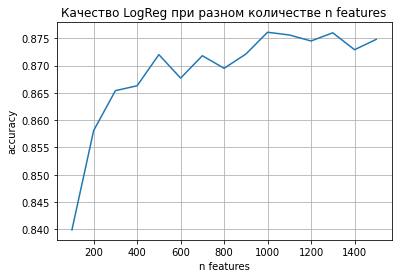

In [18]:
plt.plot(n_features, preds_feat)
plt.title('Качество LogReg при разном количестве n features')
plt.xlabel('n features')
plt.ylabel('accuracy')
plt.grid()
plt.show()

2. С увеличением n features качество улучшается и выходит на плато при n features >= 1000. Таким образом 1000 признаков является оптимальным значением.

3. В задании 1 были обучены две модели: логистическая регрессия и SVM. Качество SVM оказалось незначительно выше, чем у логистической регрессии. При этом при других запусках качество логистической регрессии может стать выше за счет других параметров w и b. Обучение SVM занимает 1,5 часа, поэтому логистическая регрессия является оптимальной моделью.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪


In [51]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.fit_transform(X)
        if self.use_PCA:
          self.pca = PCA(n_components=self.new_dim, random_state = 42)
          X_copy = self.pca.fit_transform(X)

        self.W, self.b = self._find_W_b(X_copy)
        X_copy = self.scaler2.fit_transform(np.cos(X_copy @ self.W + self.b)**3)
              
        # LinearModel
        if self.classifier == 'svm':
            self.clf = SVC(kernel='linear', probability=True, random_state=42)
        elif self.classifier == 'logreg':
            self.clf = LogisticRegression(n_jobs=-1, random_state=42)
        else:
            raise NotImplementedError('{} is not supported'.format(self.classifier))
        self.clf.fit(X_copy, y)
        return self

    def _find_W_b(self, X): 
        i = np.random.choice(X.shape[0], 2000)
        i = np.unique(i)
        j = np.random.choice(list(set([k for k in range(X.shape[0])]) - set(i)), 2000) 
        j = np.unique(j)
        dist = cdist(X[i], X[j]).flatten() 
        sigma = np.median(dist)
        W = np.random.normal(0, 1/sigma, size=(X.shape[1], self.n_features))
        b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        return W, b

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.transform(X)
        if self.use_PCA:
            X_copy = self.pca.transform(X)
        X_copy = self.scaler2.transform(np.cos(X_copy @ self.W + self.b))
        preds_proba = self.clf.predict_proba(X_copy)
        return preds_proba
                
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        preds_proba = self.predict_proba(X)
        preds = np.argmax(preds_proba, axis=1)
        return preds

In [52]:
#cos^3
RFFPipe = RFFPipeline()
RFFPipe.fit(x_train, y_train)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_logreg = np.argmax(preds_probs, axis=1)
print('RFF LogReg accuracy =', round(accuracy_score(y_test, preds_rff_logreg), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_logreg))

RFF LogReg accuracy = 0.7073
**************************************************
              precision    recall  f1-score   support

           0       0.91      0.23      0.37      1000
           1       1.00      0.89      0.94      1000
           2       0.70      0.61      0.65      1000
           3       0.74      0.81      0.78      1000
           4       0.57      0.81      0.67      1000
           5       0.79      0.92      0.85      1000
           6       0.31      0.34      0.32      1000
           7       0.73      0.80      0.76      1000
           8       0.69      0.95      0.80      1000
           9       0.97      0.72      0.82      1000

    accuracy                           0.71     10000
   macro avg       0.74      0.71      0.70     10000
weighted avg       0.74      0.71      0.70     10000



In [53]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.fit_transform(X)
        if self.use_PCA:
          self.pca = PCA(n_components=self.new_dim, random_state = 42)
          X_copy = self.pca.fit_transform(X)

        self.W, self.b = self._find_W_b(X_copy)
        X_copy = self.scaler2.fit_transform(np.sign(X_copy @ self.W + self.b))
              
        # LinearModel
        if self.classifier == 'svm':
            self.clf = SVC(kernel='linear', probability=True, random_state=42)
        elif self.classifier == 'logreg':
            self.clf = LogisticRegression(n_jobs=-1, random_state=42)
        else:
            raise NotImplementedError('{} is not supported'.format(self.classifier))
        self.clf.fit(X_copy, y)
        return self

    def _find_W_b(self, X): 
        i = np.random.choice(X.shape[0], 2000)
        i = np.unique(i)
        j = np.random.choice(list(set([k for k in range(X.shape[0])]) - set(i)), 2000) 
        j = np.unique(j)
        dist = cdist(X[i], X[j]).flatten() 
        sigma = np.median(dist)
        W = np.random.normal(0, 1/sigma, size=(X.shape[1], self.n_features))
        b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        return W, b

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.transform(X)
        if self.use_PCA:
            X_copy = self.pca.transform(X)
        X_copy = self.scaler2.transform(np.cos(X_copy @ self.W + self.b))
        preds_proba = self.clf.predict_proba(X_copy)
        return preds_proba
                
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        preds_proba = self.predict_proba(X)
        preds = np.argmax(preds_proba, axis=1)
        return preds

In [46]:
#sign вместо cos
RFFPipe = RFFPipeline()
RFFPipe.fit(x_train, y_train)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_logreg = np.argmax(preds_probs, axis=1)
print('RFF LogReg accuracy =', round(accuracy_score(y_test, preds_rff_logreg), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_logreg))

RFF LogReg accuracy = 0.0603
**************************************************
              precision    recall  f1-score   support

           0       0.02      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.05      0.18      0.07      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.07      0.42      0.12      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.06     10000
   macro avg       0.01      0.06      0.02     10000
weighted avg       0.01      0.06      0.02     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.fit_transform(X)
        if self.use_PCA:
          self.pca = PCA(n_components=self.new_dim, random_state = 42)
          X_copy = self.pca.fit_transform(X)

        self.W, self.b = self._find_W_b(X_copy)
        X_copy = self.scaler2.fit_transform(np.cos(X_copy @ self.W + self.b))
              
        # LinearModel
        if self.classifier == 'svm':
            self.clf = SVC(kernel='linear', probability=True, random_state=42)
        elif self.classifier == 'logreg':
            self.clf = LogisticRegression(n_jobs=-1, random_state=42)
        else:
            self.clf = RandomForestClassifier(random_state=42)
        self.clf.fit(X_copy, y)
        return self

    def _find_W_b(self, X): 
        i = np.random.choice(X.shape[0], 2000)
        i = np.unique(i)
        j = np.random.choice(list(set([k for k in range(X.shape[0])]) - set(i)), 2000) 
        j = np.unique(j)
        dist = cdist(X[i], X[j]).flatten() 
        sigma = np.median(dist)
        W = np.random.normal(0, 1/sigma, size=(X.shape[1], self.n_features))
        b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        return W, b

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.transform(X)
        if self.use_PCA:
            X_copy = self.pca.transform(X)
        X_copy = self.scaler2.transform(np.cos(X_copy @ self.W + self.b))
        preds_proba = self.clf.predict_proba(X_copy)
        return preds_proba
                
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        preds_proba = self.predict_proba(X)
        preds = np.argmax(preds_proba, axis=1)
        return preds

In [64]:
# Random rorest на случайных признаках
from sklearn.ensemble import RandomForestClassifier
RFFPipe = RFFPipeline(classifier='RF')
RFFPipe.fit(x_train, y_train)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_rf = np.argmax(preds_probs, axis=1)
print('RFF LogReg accuracy =', round(accuracy_score(y_test, preds_rff_rf), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_rf))

RFF LogReg accuracy = 0.8622
**************************************************
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1000
           1       0.99      0.95      0.97      1000
           2       0.76      0.78      0.77      1000
           3       0.86      0.89      0.88      1000
           4       0.78      0.80      0.79      1000
           5       0.93      0.94      0.94      1000
           6       0.68      0.59      0.63      1000
           7       0.92      0.93      0.92      1000
           8       0.94      0.96      0.95      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [75]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.fit_transform(X)
        if self.use_PCA:
          self.pca = PCA(n_components=self.new_dim, random_state = 42)
          X_copy = self.pca.fit_transform(X)

        self.W, self.b = self._find_W_b(X_copy)
        X_copy = self.scaler2.fit_transform(np.cos(X_copy @ self.W + self.b))
              
        # LinearModel
        if self.classifier == 'svm':
            self.clf = SVC(kernel='linear', probability=True, random_state=42)
        elif self.classifier == 'logreg':
            self.clf = LogisticRegression(n_jobs=-1, random_state=42)
        else:
            self.clf = LGBMClassifier(max_depth=10, learning_rate=0.2)
        self.clf.fit(X_copy, y)
        return self

    def _find_W_b(self, X): 
        i = np.random.choice(X.shape[0], 2000)
        i = np.unique(i)
        j = np.random.choice(list(set([k for k in range(X.shape[0])]) - set(i)), 2000) 
        j = np.unique(j)
        dist = cdist(X[i], X[j]).flatten() 
        sigma = np.median(dist)
        W = np.random.normal(0, 1/sigma, size=(X.shape[1], self.n_features))
        b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        return W, b

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_copy = self.scaler1.transform(X)
        if self.use_PCA:
            X_copy = self.pca.transform(X)
        X_copy = self.scaler2.transform(np.cos(X_copy @ self.W + self.b))
        preds_proba = self.clf.predict_proba(X_copy)
        return preds_proba
                
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        preds_proba = self.predict_proba(X)
        preds = np.argmax(preds_proba, axis=1)
        return preds

In [76]:
# градиентный бустинг на случайных признаках
RFFPipe = RFFPipeline(classifier='LGBM')
RFFPipe.fit(x_train, y_train)

preds_probs = RFFPipe.predict_proba(x_test)
preds_rff_b = np.argmax(preds_probs, axis=1)
print('RFF LogReg accuracy =', round(accuracy_score(y_test, preds_rff_b), 4))
print('*'*50)
print(classification_report(y_test, preds_rff_b))

RFF LogReg accuracy = 0.8768
**************************************************
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.78      0.79      0.79      1000
           3       0.89      0.90      0.89      1000
           4       0.78      0.81      0.80      1000
           5       0.96      0.95      0.96      1000
           6       0.68      0.65      0.67      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Возведение косинуса в различные степени не дает прирост качества (для примера оставила степень 3). Если брать знак скалярного произведения, то качесво близко к случайному угадыванию.

Применение случайного леса в качестве классификатора дает качество хуже, чем у логистической регрессии и SVM.

Градиентный бустинг на случайных признаках дает качество немного выше, чем логистическая регрессия, но не дотягивает до SVM на случайных признаках.